## Load Airport and Flow Data

In [11]:
%load_ext autoreload
%autoreload 2

from scipy.signal import savgol_filter
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

rng = np.random.default_rng()
flow_matrix_path = "../recovery_rate/recovery_rate_training_dataframes/data/all_time_flight_flow_df_rev1.pickle"
flight_flow_data = pd.read_pickle(flow_matrix_path)

infection_matrix_path = "../recovery_rate/recovery_rate_training_dataframes/data/all_time_infection_rate_df_rev1.pickle"
infection_matrix_df = pd.read_pickle(infection_matrix_path)

apt_df_path = "../recovery_rate/recovery_rate_training_dataframes/data/airport_state_weather_prediction_added_rev1.pickle"
airport_df = pd.read_pickle(apt_df_path)

## Load DL Model and Dataset

In [15]:
from dataset import RecoveryRateDataset
from torch.utils.data import DataLoader
from model_lightning import LSTMEstimator
import torch

SEQUENCE_LENGTH = 3
features_to_drop = ['reg_type', 'reg_bool_type', 'reg_cause', "weather_prediction"]

rr_dataset = RecoveryRateDataset(apt_df_path, features_to_drop=features_to_drop, sequence_length=SEQUENCE_LENGTH,
                                 fill_with='backfill')

rr_dataloader = DataLoader(rr_dataset, batch_size=133, shuffle=False, num_workers=8)

model = LSTMEstimator(len(rr_dataset.feature_names), initial_dense_layer_size=512, dense_parameter_multiplier=1,
                          dense_layer_count=8, lstm_layer_count=2, lstm_hidden_units=512, dropout=0.5,
                          sequence_length=SEQUENCE_LENGTH, loss="huber")

checkpoint = torch.load("artifacts/model-35cgln33:v24/model.ckpt", map_location=torch.device("cpu"))
model.load_state_dict(checkpoint["state_dict"])
model.eval()

LSTMEstimator(
  (feature_extracting_layers): Sequential(
    (linear0): Linear(in_features=16, out_features=512, bias=True)
    (relu0): LeakyReLU(negative_slope=0.01)
    (dropout0): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=512, out_features=512, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (dropout1): Dropout(p=0.5, inplace=False)
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
    (dropout2): Dropout(p=0.5, inplace=False)
    (linear3): Linear(in_features=512, out_features=512, bias=True)
    (relu3): LeakyReLU(negative_slope=0.01)
    (dropout3): Dropout(p=0.5, inplace=False)
    (linear4): Linear(in_features=512, out_features=512, bias=True)
    (relu4): LeakyReLU(negative_slope=0.01)
    (dropout4): Dropout(p=0.5, inplace=False)
    (linear5): Linear(in_features=512, out_features=512, bias=True)
    (relu5): LeakyReLU(negative_slope=0.01)
    (dropout5): Dropout(p=0.5, inplace=Fa

In [16]:
from tqdm import tqdm
rr_prediction_list = []

for x, y in tqdm(rr_dataloader):
    rr_prediction_list.append(model(x).detach().numpy())

rr_prediction_list = [np.squeeze(array, axis=1) for array in rr_prediction_list]
rr_prediction_list.insert(0, rr_prediction_list[0])
rr_prediction_list.insert(0, rr_prediction_list[0])
rr_prediction_list.insert(0, rr_prediction_list[0])
rr_prediction_list = [np.diag(array) for array in rr_prediction_list]

100%|██████████| 4341/4341 [17:30<00:00,  4.13it/s]


## Create RR, IR and FR Columns

In [17]:
mult_index = pd.MultiIndex.from_product([np.arange(np.datetime64("2018-01-01"), np.datetime64("2018-07-01")), range(0, 96, 4)], names=["date", "tw"])
new_df = pd.DataFrame(index=mult_index)

ff_list = []
inf_list = []
rr_list = []
p_state_list = []
median_rr_list = [np.diag(airport_df["recovery_rate"].groupby("apt", sort=False).median().reindex(airport_df.index.unique("apt")).values)] * len(range(0, len(flight_flow_data), 133))

for i in range(0, len(flight_flow_data), 133):
    rr_list.append(np.diag(airport_df.loc[:, "recovery_rate"].fillna(method="backfill").fillna(airport_df.loc[:, "recovery_rate"].median()).iloc[i:i+133].values))
    p_state_list.append(airport_df.loc[:, "norm_delay_per_f"].iloc[i:i+133].values.clip(min=0, max=1))
    ff_list.append(flight_flow_data.iloc[i:i+133, :].values)
    inf_list.append(infection_matrix_df.iloc[i:i+133, :].values)

new_df["rr_vector"] = rr_list
new_df["p_vector"] = p_state_list
new_df["infmat"] = inf_list
new_df["flowmat"] = ff_list
new_df["median_rr"] = median_rr_list
new_df["rr_prediction"] = rr_prediction_list

## Delta P plots


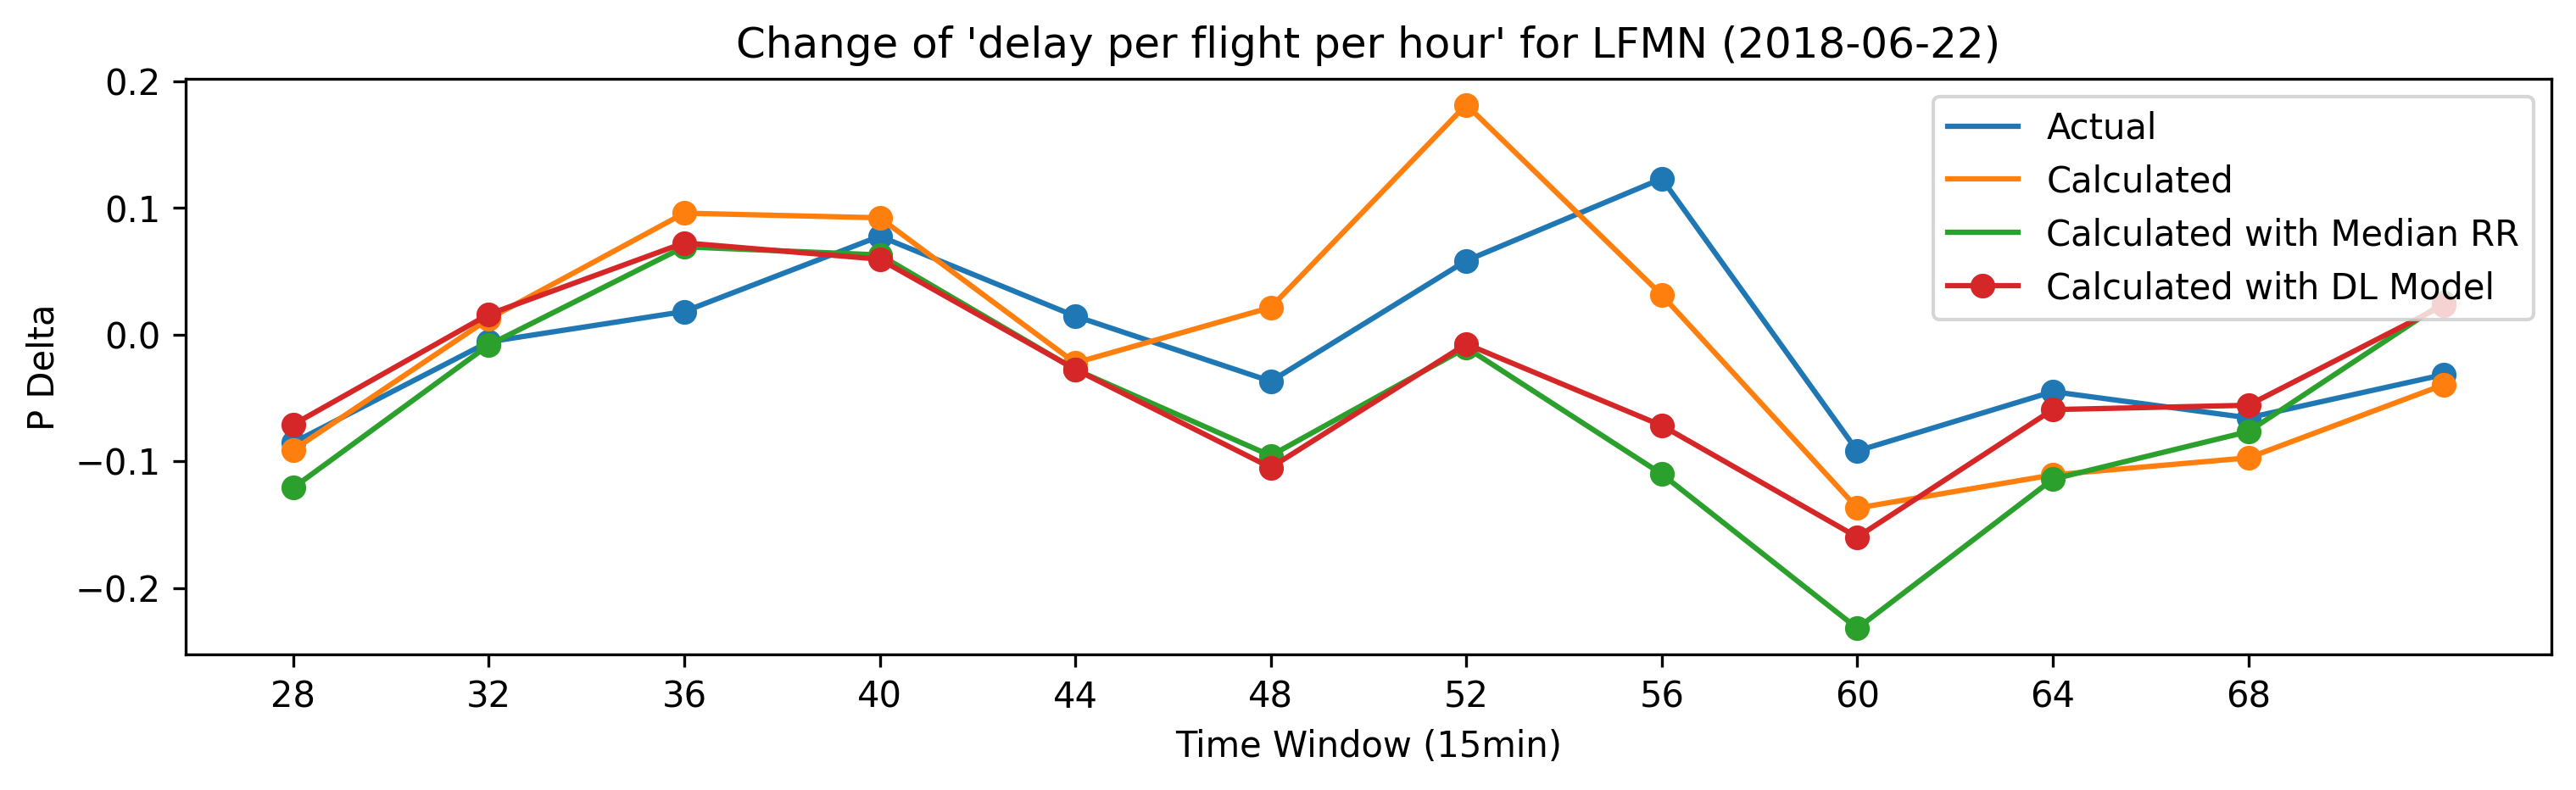

In [35]:
random = True
tw_tuple =(24, 72, 4)
tw=slice(tw_tuple[0], tw_tuple[1], 1)
if random:
    date = str(rng.choice(np.arange(np.datetime64("2018-01-01"), np.datetime64("2018-07-01"))))
    apt_idx = rng.integers(0, 133)
else:
    date="2018-04-05"
    apt_idx = 5
    
index = (date, tw)

apt_name = airport_df.index.unique("apt").tolist()[apt_idx]

def diff_prop(slice_df, inf_label = "infmat", rr_label="rr_vector", p_label="p_vector"):
    return (((slice_df["infmat"] - slice_df[rr_label]) @ slice_df[p_label]) - ((slice_df["infmat"] @ slice_df[p_label]) * slice_df[p_label])) / 1

slice_df = deepcopy(new_df.loc[index, :])

def apt_index(vector):
    return vector[apt_idx]

plot_kwargs = dict(figsize=(12, 3), xlabel="Time Window (15min)", ylabel="P Delta", legend=True, xticks=range(tw_tuple[0]+4, tw_tuple[1], 4), title=f"Change of 'delay per flight per hour' for {apt_name} ({date})",
                   marker="o")

slice_df["calc_p"] = slice_df.apply(diff_prop, axis=1).values
slice_df["calc_p_median_rr"] = slice_df.apply(diff_prop, axis=1, rr_label="median_rr").values
slice_df["calc_p_rr_prediction"] = slice_df.apply(diff_prop, axis=1, rr_label="rr_prediction").values

slice_df["p_vector"].reset_index(level="date", drop=True).apply(apt_index).diff().plot(**plot_kwargs, label="Actual")
slice_df["calc_p"].reset_index(level="date", drop=True).apply(apt_index).shift(1).plot(**plot_kwargs, label="Calculated")
slice_df["calc_p_median_rr"].reset_index(level="date", drop=True).apply(apt_index).shift(1).plot(**plot_kwargs, label="Calculated with Median RR")
slice_df["calc_p_rr_prediction"].reset_index(level="date", drop=True).apply(apt_index).shift(1).plot(**plot_kwargs, label="Calculated with DL Model")

plt.show()

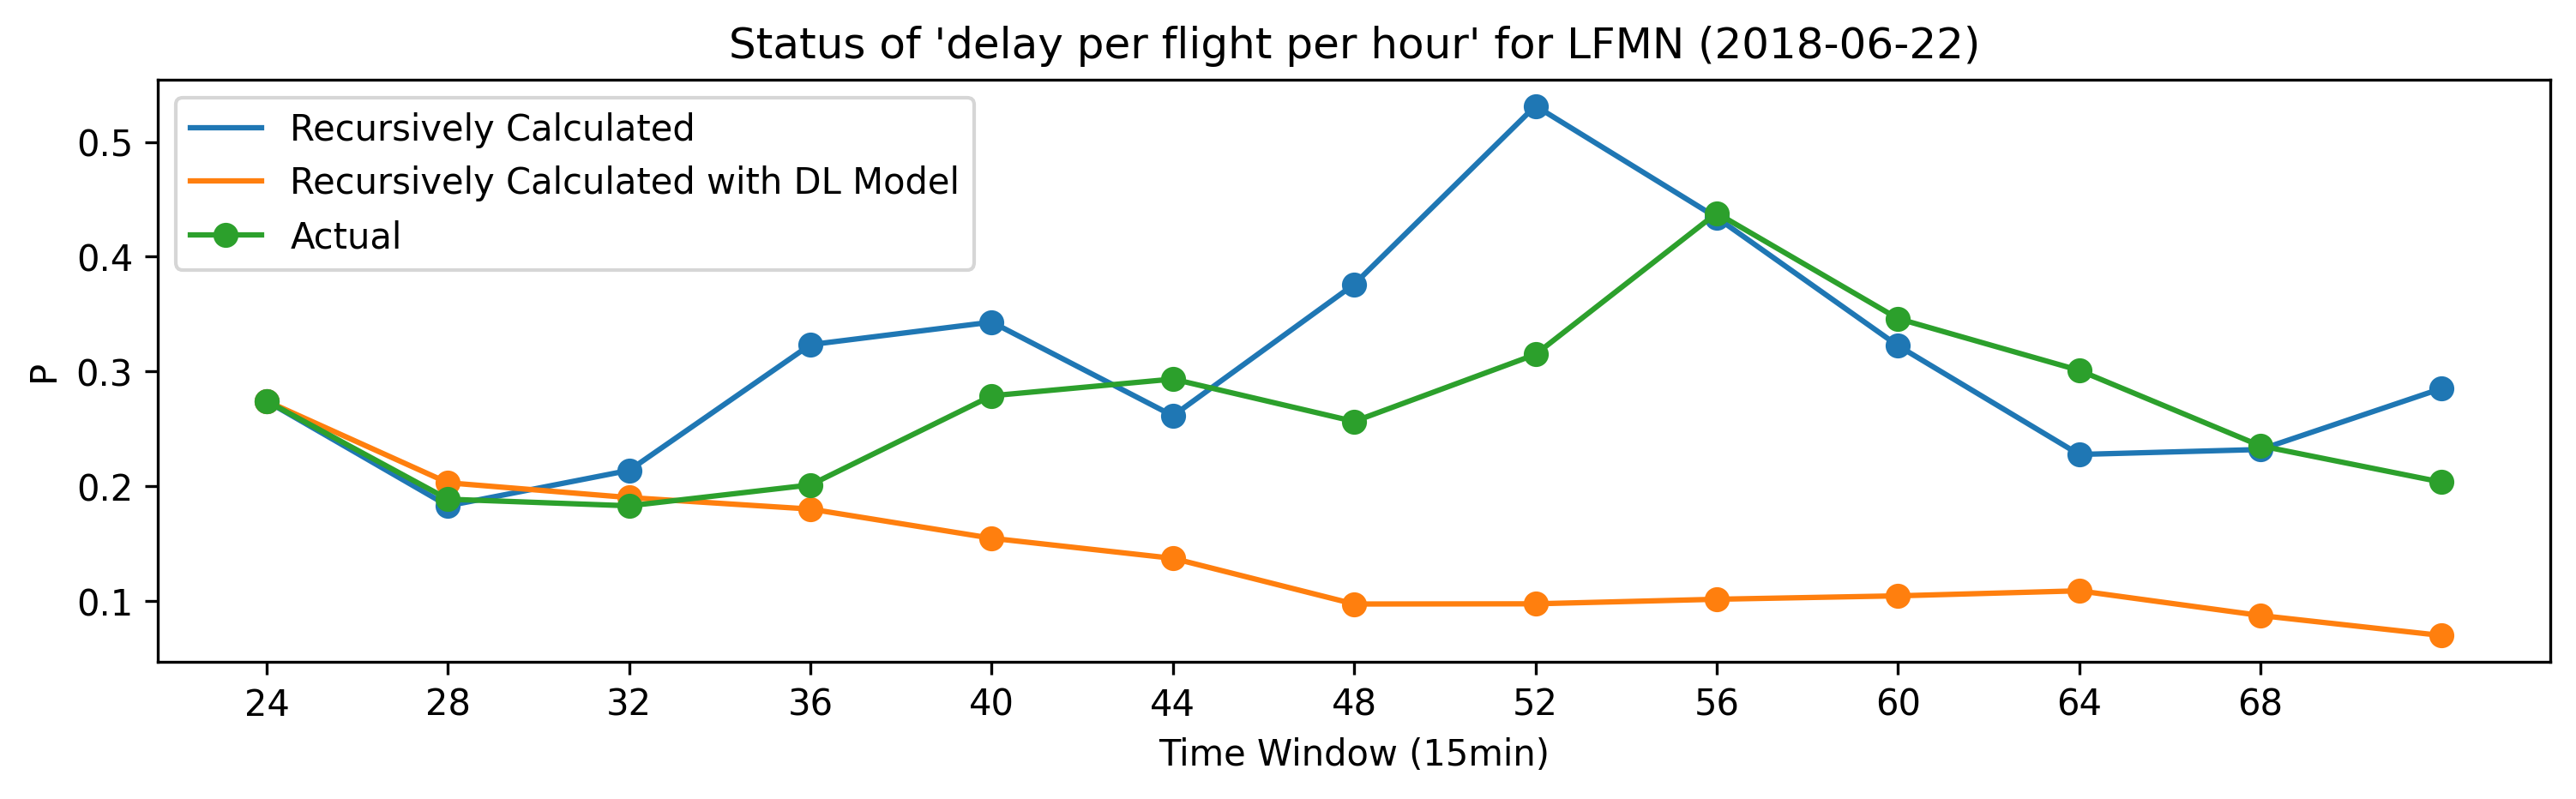

In [36]:
plot_kwargs_cumulative = dict(figsize=(12, 3), xlabel="Time Window (15min)", ylabel="P", legend=True, xticks=range(tw_tuple[0], tw_tuple[1], 4), title=f"Status of 'delay per flight per hour' for {apt_name} ({date})",
                   marker="o")

slice_df["p_vector_cumulative"] = slice_df["p_vector"].values
slice_df["p_vector_cumulative_pred"] = slice_df["p_vector"].values

for idx in range(len(slice_df) - 1):
    slice_df["p_dots_cumulative"] = slice_df.apply(diff_prop, axis=1, p_label="p_vector_cumulative").values
    slice_df["p_vector_cumulative"][idx+1] = slice_df["p_vector_cumulative"][idx] + slice_df["p_dots_cumulative"][idx]
    slice_df["p_vector_cumulative"][idx+1] = np.clip(slice_df["p_vector_cumulative"][idx+1], 0, 1)
    
    slice_df["p_dots_cumulative_pred"] = slice_df.apply(diff_prop, axis=1, rr_label="rr_prediction", p_label="p_vector_cumulative_pred").values
    slice_df["p_vector_cumulative_pred"][idx+1] = slice_df["p_vector_cumulative_pred"][idx] + slice_df["p_dots_cumulative_pred"][idx]
    slice_df["p_vector_cumulative_pred"][idx+1] = np.clip(slice_df["p_vector_cumulative_pred"][idx+1], 0, 1)
    
    
slice_df["p_vector_cumulative"].reset_index(level="date", drop=True).apply(apt_index).plot(**plot_kwargs_cumulative, label="Recursively Calculated")
slice_df["p_vector_cumulative_pred"].reset_index(level="date", drop=True).apply(apt_index).plot(**plot_kwargs_cumulative, label="Recursively Calculated with DL Model")
slice_df["p_vector"].reset_index(level="date", drop=True).apply(apt_index).plot(**plot_kwargs_cumulative, label="Actual")
plt.show()

## Delta P Plots with Uncertainties

In [42]:
from uncertainty_matrix_to_discrete import UncertaintyMatrix, divide_flowmats_to_interval, convert_flowmat_to_infmat

arrival_times = rng.integers(10, 150, size=(133, 133))
uncertainty_matrix = UncertaintyMatrix(new_df.loc[index, "flowmat"].iloc[0], mean_values=arrival_times)

sample_flowmats = [uncertainty_matrix.draw_sample() for i in range(100)]
sample_flowmats_divided = [divide_flowmats_to_interval(sample_flowmat, interval=15) for sample_flowmat in sample_flowmats]
sample_infmats = convert_flowmat_to_infmat(sample_flowmats_divided)

flowmat_no_uncertainty = [UncertaintyMatrix(new_df.loc[index, "flowmat"].iloc[0], mean_values=arrival_times, 
                                                 std_values=np.zeros((133, 133))).draw_sample()]
flowmat_no_uncertainty_divided = [divide_flowmats_to_interval(sample_flowmat, interval=15) for sample_flowmat in flowmat_no_uncertainty]
infmat_no_uncertainty = convert_flowmat_to_infmat(flowmat_no_uncertainty_divided)


plot_kwargs_for_uncertainty = dict(figsize=(12, 3), xlabel="Time Window (15min)", ylabel="P Delta", xticks=range(28, 76, 4), title=f"Change of 'delay per flight per hour' for {apt_name} ({date})",
                   linestyle="--", alpha=0.2, color="b")

calculation_history = []
for infmat_sequence in sample_infmats:
    df = deepcopy(slice_df.iloc[0:len(infmat_sequence), :])
    df["new_infmat"] = infmat_sequence
    df["calc_with_new_infmat"] = df.apply(diff_prop, inf_label="new_infmat", axis=1).values
    df["calc_with_new_infmat"].iloc[0:-1].reset_index(level="date", drop=True).apply(apt_index).shift(1).plot(**plot_kwargs_for_uncertainty)
    calculation_history.append(df["calc_with_new_infmat"].iloc[0:-1].reset_index(level="date", drop=True).apply(apt_index).shift(1).values)
    
for infmat_sequence in infmat_no_uncertainty:
    df = deepcopy(slice_df.iloc[0:len(infmat_sequence), :])
    df["new_infmat"] = infmat_sequence
    df["calc_with_new_infmat"] = df.apply(diff_prop, inf_label="new_infmat", axis=1).values
    df["calc_with_new_infmat"].iloc[0:-1].reset_index(level="date", drop=True).apply(apt_index).shift(1).plot(**plot_kwargs_for_uncertainty, label="Calculated w/ no uncertainty")
    
#df["calc_p"].reset_index(level="date", drop=True).apply(apt_index).shift(1).plot(**plot_kwargs, label="Calculated", color="b")
df["p_vector"].reset_index(level="date", drop=True).apply(apt_index).diff().plot(**plot_kwargs, label="Actual", color="orange")
plt.show()

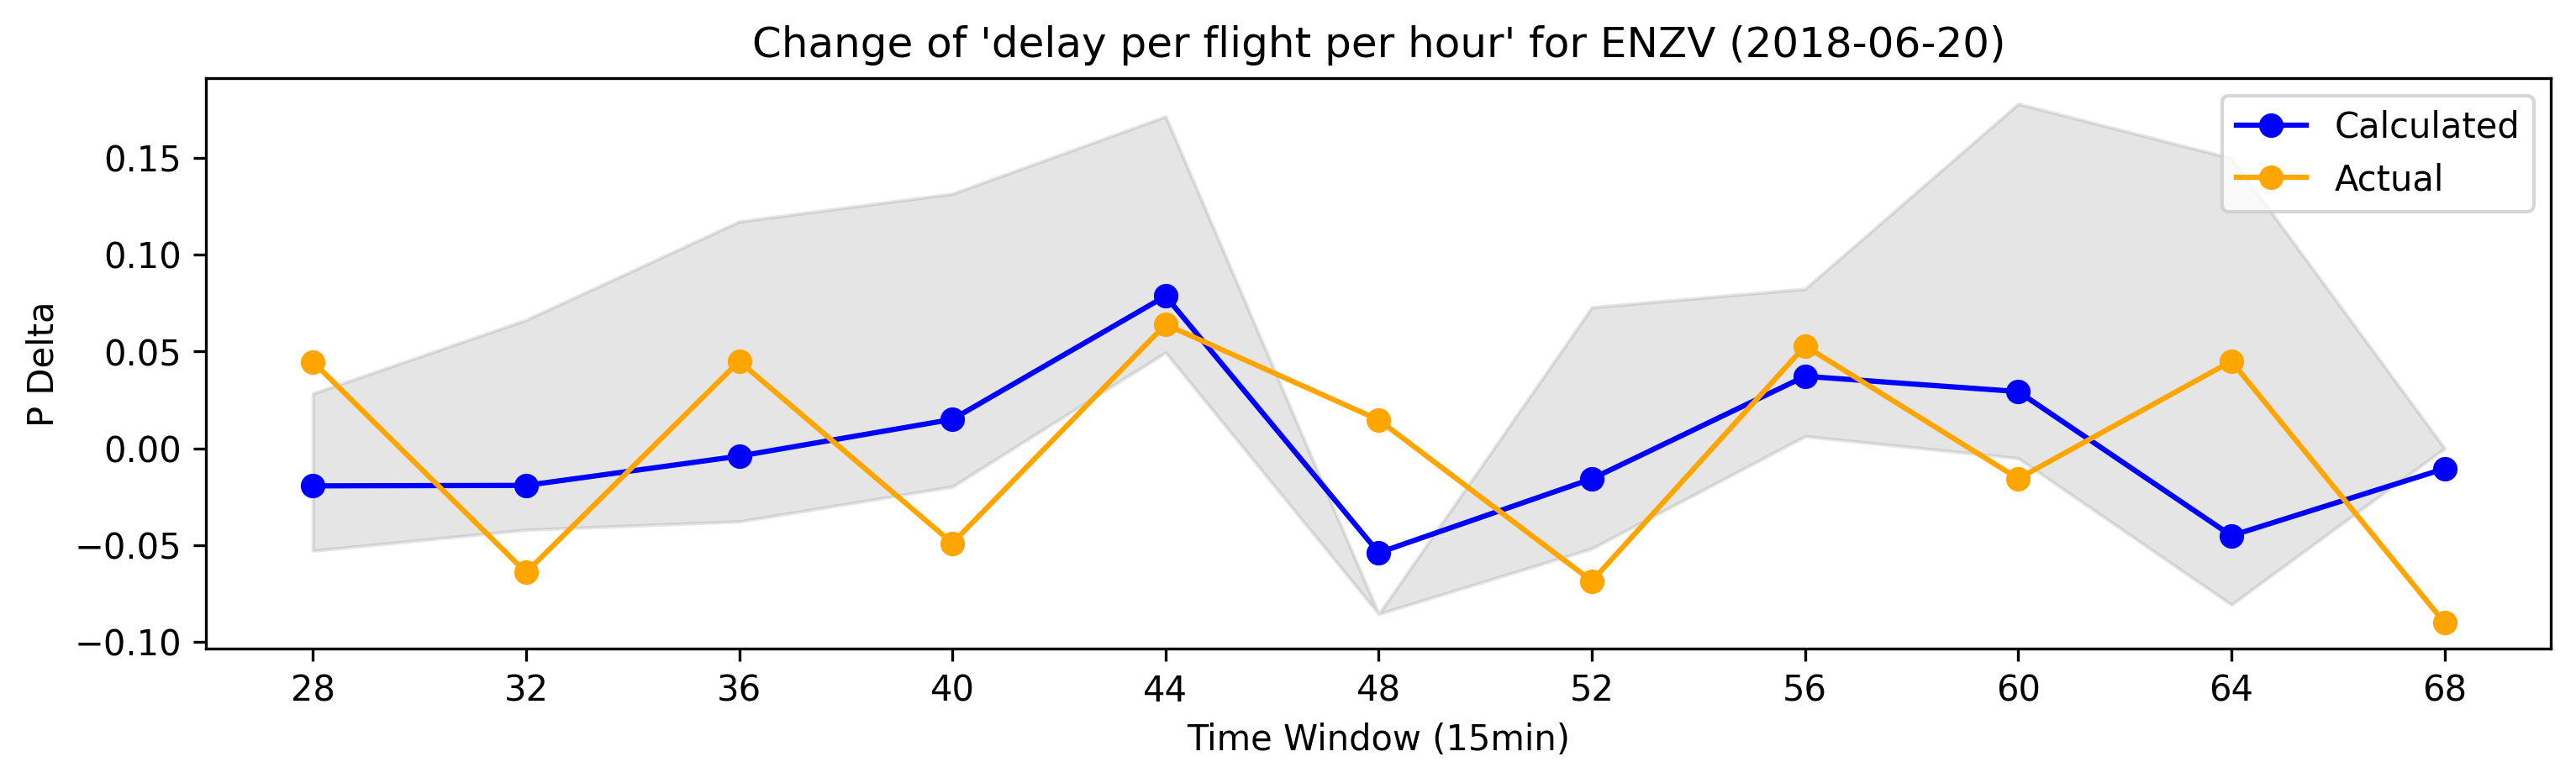

In [124]:
def pad_arrays(expected_len, array_list):
    padded_calc_history = []
    expected_array_len = 12

    for array in calculation_history:
        
        len_deficit = expected_array_len - array.shape[0]
        while len_deficit < 0:
            expected_array_len = array.shape[0]
            len_deficit = expected_array_len - array.shape[0]
            
        if len_deficit != 0:
            padded_calc_history.append(np.pad(array, (0, len_deficit), constant_values=0))
        else:
            padded_calc_history.append(array)
            
    return padded_calc_history

df["calc_p"].reset_index(level="date", drop=True).apply(apt_index).shift(1).plot(**plot_kwargs, label="Calculated", color="b")
df["p_vector"].reset_index(level="date", drop=True).apply(apt_index).diff().plot(**plot_kwargs, label="Actual", color="orange")

padded_calc_history = pad_arrays(12, calculation_history)
max_p_delta_values = np.nan_to_num(np.vstack(padded_calc_history)).max(axis=0)
min_p_delta_values = np.nan_to_num(np.vstack(padded_calc_history)).min(axis=0)
plt.gca().fill_between(x=range(28, 72, 4), y1=max_p_delta_values[1:], y2=min_p_delta_values[1:], color="gray", alpha=0.2)